## Simple Autoencoders and Variational Autoencoders

This exercise will guide you through creating a regular autoencoder and a variational one. We'll also sample from the learned latent spaces to illustrate how much better variational autoencoders are at generative modeling. Along the way, we'll visualize the latent space produced by each of the autoencoders to get an idea of what's happening behind the scenes.

To start, we'll create a simple autoencoder. Fill in the TODOs. The cell below just imports the necessary modules and takes care of device placement.

In [1]:
import os
import torch
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as tvtransforms
import torchvision.utils as vutils
from torch.utils.data import TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

img_shape = (1, 28, 28)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 64

In [2]:
class Autoencoder(nn.Module):

    def __init__(self, latent_size):
        # One of the arguments in the constructor is latent_size, which
        # indicates how many nodes you want to downsample the input to.
        # Recall the encoding portion of AE reduces dimensionality of the input

        super(Autoencoder, self).__init__()
        self.latent_size = latent_size
        # We'll be working with MNIST, so the input dimension will be 784.
        self.encoder1 = nn.Linear(784, 512)
        # TODO: Create two more encoding layers that successively downscale the input
        self.encoder2 = nn.Linear(512,256)
        self.encoder3 = nn.Linear(256,128)
        
        # reduced dimensionality of input (final encoding)
        self.bottleneck = nn.Linear(128, latent_size)

        # decoding portion of AE, take encoded data and decode to original dimensionality
        self.decoder1 = nn.Linear(latent_size, 128)
        self.decoder2 = nn.Linear(128, 256)
        self.decoder3 = nn.Linear(256, 512)
        # output original dimensionality (784 in the case of MNIST)
        self.out = nn.Linear(512, 784)
    
    def encode(self, x):
        enc1 = F.relu(self.encoder1(x))
        enc2 = F.relu(self.encoder2(enc1))
        enc3 = F.relu(self.encoder3(enc2))
        encoded_representation = self.bottleneck(enc3)
        return encoded_representation
    
    def decode(self, x):
        dec1 = F.relu(self.decoder1(x))
        dec2 = F.relu(self.decoder2(dec1))
        dec3 = F.relu(self.decoder3(dec2))
        out = self.out(dec3)
        return out
        
    def forward(self, x):
        # forward mode, pass input through activation funtions
        # Simple!
        decoded = self.decode(self.encode(x))
        return decoded
        

## Read in MNIST Data
We'll use these loaders for training and testing our autoencoders.

In [3]:
batch_size = 64
os.makedirs("data/mnist", exist_ok=True)
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        "data/mnist",
        train=True,
        download=True,
        transform=tvtransforms.Compose(
            [tvtransforms.ToTensor()]
        ),
    ),
    batch_size=batch_size,
    drop_last=True,
    num_workers=2,
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        "data/mnist",
        train=False,
        download=True,
        transform=tvtransforms.Compose(
            [tvtransforms.ToTensor()]
        ),
    ),
    batch_size=batch_size,
    drop_last=True,
    num_workers=2,
    shuffle=True,
)

In [4]:
lr = .001
epochs = 5
latent_size = 20 # Size of the bottleneck layer
model = Autoencoder(latent_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
# TODO: what should the loss function be here for real-valued outputs?
criterion = nn.MSELoss()
for epoch in range(1, epochs + 1):
     for data, _ in train_loader:
        optimizer.zero_grad()
        data = data.view(-1, 28*28) # Reshape the MNIST image to batch_size x 784
        output = model.forward(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        print('Epoch: {}/{}.............{}'.format(epoch, epochs, loss.item()), end='\n')

Epoch: 1/5.............0.10874197632074356
Epoch: 1/5.............0.1142650693655014
Epoch: 1/5.............0.1062861755490303
Epoch: 1/5.............0.09604647010564804
Epoch: 1/5.............0.08635544031858444
Epoch: 1/5.............0.07777366042137146
Epoch: 1/5.............0.0729341134428978
Epoch: 1/5.............0.07585129141807556
Epoch: 1/5.............0.06977681070566177
Epoch: 1/5.............0.06749948859214783
Epoch: 1/5.............0.06619006395339966
Epoch: 1/5.............0.0693056583404541
Epoch: 1/5.............0.06651691347360611
Epoch: 1/5.............0.06319081783294678
Epoch: 1/5.............0.06442735344171524
Epoch: 1/5.............0.06841404736042023
Epoch: 1/5.............0.0709671601653099
Epoch: 1/5.............0.06893379986286163
Epoch: 1/5.............0.06363294273614883
Epoch: 1/5.............0.0645509883761406
Epoch: 1/5.............0.0678045004606247
Epoch: 1/5.............0.06980802863836288
Epoch: 1/5.............0.06309929490089417
Epoch: 1/5........

Epoch: 1/5.............0.04514595866203308
Epoch: 1/5.............0.044875144958496094
Epoch: 1/5.............0.04915760084986687
Epoch: 1/5.............0.051030486822128296
Epoch: 1/5.............0.044648006558418274
Epoch: 1/5.............0.051556266844272614
Epoch: 1/5.............0.04441886022686958
Epoch: 1/5.............0.044874414801597595
Epoch: 1/5.............0.04425514116883278
Epoch: 1/5.............0.048848751932382584
Epoch: 1/5.............0.04743695631623268
Epoch: 1/5.............0.04582985118031502
Epoch: 1/5.............0.044981859624385834
Epoch: 1/5.............0.04421328380703926
Epoch: 1/5.............0.044658560305833817
Epoch: 1/5.............0.04447552561759949
Epoch: 1/5.............0.046928584575653076
Epoch: 1/5.............0.04788194224238396
Epoch: 1/5.............0.04583410918712616
Epoch: 1/5.............0.046603016555309296
Epoch: 1/5.............0.04683994874358177
Epoch: 1/5.............0.044376544654369354
Epoch: 1/5.............0.045583758503198624

Epoch: 1/5.............0.032263945788145065
Epoch: 1/5.............0.03178077191114426
Epoch: 1/5.............0.033730532974004745
Epoch: 1/5.............0.031381696462631226
Epoch: 1/5.............0.034420374780893326
Epoch: 1/5.............0.031760137528181076
Epoch: 1/5.............0.03138141334056854
Epoch: 1/5.............0.037217654287815094
Epoch: 1/5.............0.03230518102645874
Epoch: 1/5.............0.033154819160699844
Epoch: 1/5.............0.030573811382055283
Epoch: 1/5.............0.0339554026722908
Epoch: 1/5.............0.033460695296525955
Epoch: 1/5.............0.031968146562576294
Epoch: 1/5.............0.03638124465942383
Epoch: 1/5.............0.03692792356014252
Epoch: 1/5.............0.033000435680150986
Epoch: 1/5.............0.03252490609884262
Epoch: 1/5.............0.032674338668584824
Epoch: 1/5.............0.031400103121995926
Epoch: 1/5.............0.03378340229392052
Epoch: 1/5.............0.031626660376787186
Epoch: 1/5.............0.0328781269490718

Epoch: 1/5.............0.029174070805311203
Epoch: 1/5.............0.03128104284405708
Epoch: 1/5.............0.029889211058616638
Epoch: 1/5.............0.02873411774635315
Epoch: 1/5.............0.02962576039135456
Epoch: 1/5.............0.029503772035241127
Epoch: 1/5.............0.028693072497844696
Epoch: 1/5.............0.029024729505181313
Epoch: 1/5.............0.029019730165600777
Epoch: 1/5.............0.02959143929183483
Epoch: 1/5.............0.027142373844981194
Epoch: 1/5.............0.03196757286787033
Epoch: 1/5.............0.027652909979224205
Epoch: 1/5.............0.03016725555062294
Epoch: 1/5.............0.028143635019659996
Epoch: 1/5.............0.02823525108397007
Epoch: 1/5.............0.029099995270371437
Epoch: 1/5.............0.02912953495979309
Epoch: 1/5.............0.02994835563004017
Epoch: 1/5.............0.027111763134598732
Epoch: 1/5.............0.02642836607992649
Epoch: 1/5.............0.0264098159968853
Epoch: 1/5.............0.026509219780564308


Epoch: 1/5.............0.0263991542160511
Epoch: 1/5.............0.026094140484929085
Epoch: 1/5.............0.028257276862859726
Epoch: 1/5.............0.026704242452979088
Epoch: 1/5.............0.025862663984298706
Epoch: 1/5.............0.024441136047244072
Epoch: 1/5.............0.025320973247289658
Epoch: 1/5.............0.025200361385941505
Epoch: 1/5.............0.02794777788221836
Epoch: 1/5.............0.028170853853225708
Epoch: 1/5.............0.024704553186893463
Epoch: 1/5.............0.025525977835059166
Epoch: 1/5.............0.028116144239902496
Epoch: 1/5.............0.02816546894609928
Epoch: 1/5.............0.02681640163064003
Epoch: 1/5.............0.026148134842514992
Epoch: 1/5.............0.026554172858595848
Epoch: 1/5.............0.027426188811659813
Epoch: 1/5.............0.028648756444454193
Epoch: 1/5.............0.028268462046980858
Epoch: 1/5.............0.024503134191036224
Epoch: 1/5.............0.028756920248270035
Epoch: 1/5.............0.027237016707

Epoch: 2/5.............0.026538504287600517
Epoch: 2/5.............0.024156277999281883
Epoch: 2/5.............0.025763027369976044
Epoch: 2/5.............0.023780981078743935
Epoch: 2/5.............0.02370627596974373
Epoch: 2/5.............0.02637796476483345
Epoch: 2/5.............0.023698104545474052
Epoch: 2/5.............0.02587408944964409
Epoch: 2/5.............0.02094554901123047
Epoch: 2/5.............0.023687344044446945
Epoch: 2/5.............0.026650413870811462
Epoch: 2/5.............0.02543504908680916
Epoch: 2/5.............0.025981655344367027
Epoch: 2/5.............0.024596793577075005
Epoch: 2/5.............0.026142261922359467
Epoch: 2/5.............0.024256223812699318
Epoch: 2/5.............0.02645239047706127
Epoch: 2/5.............0.025609761476516724
Epoch: 2/5.............0.02363351359963417
Epoch: 2/5.............0.022621775045990944
Epoch: 2/5.............0.022551368921995163
Epoch: 2/5.............0.025622839108109474
Epoch: 2/5.............0.02541377581655

Epoch: 2/5.............0.02113299071788788
Epoch: 2/5.............0.02233937568962574
Epoch: 2/5.............0.024807725101709366
Epoch: 2/5.............0.025279110297560692
Epoch: 2/5.............0.02326401323080063
Epoch: 2/5.............0.02550923265516758
Epoch: 2/5.............0.023765292018651962
Epoch: 2/5.............0.024660499766469002
Epoch: 2/5.............0.02293212153017521
Epoch: 2/5.............0.024074675515294075
Epoch: 2/5.............0.022998640313744545
Epoch: 2/5.............0.02184196375310421
Epoch: 2/5.............0.026372145861387253
Epoch: 2/5.............0.0228827316313982
Epoch: 2/5.............0.022892212495207787
Epoch: 2/5.............0.02253527007997036
Epoch: 2/5.............0.023907151073217392
Epoch: 2/5.............0.024900022894144058
Epoch: 2/5.............0.022906862199306488
Epoch: 2/5.............0.02256426215171814
Epoch: 2/5.............0.021123765036463737
Epoch: 2/5.............0.02504625916481018
Epoch: 2/5.............0.022419705986976624

Epoch: 2/5.............0.022014012560248375
Epoch: 2/5.............0.021546674892306328
Epoch: 2/5.............0.021587824448943138
Epoch: 2/5.............0.021299785003066063
Epoch: 2/5.............0.023298094049096107
Epoch: 2/5.............0.021811366081237793
Epoch: 2/5.............0.022475315257906914
Epoch: 2/5.............0.02300320379436016
Epoch: 2/5.............0.023263409733772278
Epoch: 2/5.............0.01882498897612095
Epoch: 2/5.............0.021561987698078156
Epoch: 2/5.............0.02310863882303238
Epoch: 2/5.............0.02358894981443882
Epoch: 2/5.............0.02151506021618843
Epoch: 2/5.............0.022099576890468597
Epoch: 2/5.............0.021154260262846947
Epoch: 2/5.............0.021025437861680984
Epoch: 2/5.............0.0211336687207222
Epoch: 2/5.............0.022099044173955917
Epoch: 2/5.............0.020826909691095352
Epoch: 2/5.............0.023892289027571678
Epoch: 2/5.............0.022729968652129173
Epoch: 2/5.............0.02579504065215

Epoch: 2/5.............0.022210877388715744
Epoch: 2/5.............0.020514708012342453
Epoch: 2/5.............0.020734446123242378
Epoch: 2/5.............0.020941918715834618
Epoch: 2/5.............0.02040121890604496
Epoch: 2/5.............0.019329404458403587
Epoch: 2/5.............0.022541673853993416
Epoch: 2/5.............0.022024672478437424
Epoch: 2/5.............0.021692147478461266
Epoch: 2/5.............0.019567061215639114
Epoch: 2/5.............0.021464956924319267
Epoch: 2/5.............0.02272343449294567
Epoch: 2/5.............0.02045297436416149
Epoch: 2/5.............0.020852750167250633
Epoch: 2/5.............0.021656576544046402
Epoch: 2/5.............0.024029141291975975
Epoch: 2/5.............0.020263519138097763
Epoch: 2/5.............0.021714331582188606
Epoch: 2/5.............0.02208561822772026
Epoch: 2/5.............0.0191635824739933
Epoch: 2/5.............0.020561689510941505
Epoch: 2/5.............0.02148500271141529
Epoch: 2/5.............0.02247140929102

Epoch: 2/5.............0.02216343954205513
Epoch: 2/5.............0.02281499095261097
Epoch: 2/5.............0.02209382690489292
Epoch: 2/5.............0.02084938809275627
Epoch: 2/5.............0.02128022536635399
Epoch: 2/5.............0.01898340880870819
Epoch: 2/5.............0.022123463451862335
Epoch: 2/5.............0.019094552844762802
Epoch: 2/5.............0.021251359954476357
Epoch: 2/5.............0.022090043872594833
Epoch: 2/5.............0.019233262166380882
Epoch: 2/5.............0.023195704445242882
Epoch: 2/5.............0.02067725732922554
Epoch: 2/5.............0.01874297484755516
Epoch: 2/5.............0.020216358825564384
Epoch: 2/5.............0.0237334705889225
Epoch: 2/5.............0.01919318549335003
Epoch: 2/5.............0.020094119012355804
Epoch: 2/5.............0.021233806386590004
Epoch: 2/5.............0.020989378914237022
Epoch: 2/5.............0.021729014813899994
Epoch: 2/5.............0.020090796053409576
Epoch: 2/5.............0.021180322393774986

Epoch: 3/5.............0.019346166402101517
Epoch: 3/5.............0.021121317520737648
Epoch: 3/5.............0.02056780830025673
Epoch: 3/5.............0.021699395030736923
Epoch: 3/5.............0.019366329535841942
Epoch: 3/5.............0.02106211706995964
Epoch: 3/5.............0.01946469582617283
Epoch: 3/5.............0.018741561099886894
Epoch: 3/5.............0.02215922810137272
Epoch: 3/5.............0.020129850134253502
Epoch: 3/5.............0.019459161907434464
Epoch: 3/5.............0.02060619741678238
Epoch: 3/5.............0.020004598423838615
Epoch: 3/5.............0.019773270934820175
Epoch: 3/5.............0.020380189642310143
Epoch: 3/5.............0.021522164344787598
Epoch: 3/5.............0.02101236954331398
Epoch: 3/5.............0.01923849806189537
Epoch: 3/5.............0.01851697638630867
Epoch: 3/5.............0.019125420600175858
Epoch: 3/5.............0.018679644912481308
Epoch: 3/5.............0.01812935248017311
Epoch: 3/5.............0.0216815285384655

Epoch: 3/5.............0.01902901940047741
Epoch: 3/5.............0.016794594004750252
Epoch: 3/5.............0.019857162609696388
Epoch: 3/5.............0.017930934205651283
Epoch: 3/5.............0.01948399655520916
Epoch: 3/5.............0.01918969303369522
Epoch: 3/5.............0.018314098939299583
Epoch: 3/5.............0.017987864091992378
Epoch: 3/5.............0.020712994039058685
Epoch: 3/5.............0.01985080912709236
Epoch: 3/5.............0.019703181460499763
Epoch: 3/5.............0.02077344059944153
Epoch: 3/5.............0.01992928795516491
Epoch: 3/5.............0.01895306631922722
Epoch: 3/5.............0.01885334402322769
Epoch: 3/5.............0.020090380683541298
Epoch: 3/5.............0.020505322143435478
Epoch: 3/5.............0.01789190247654915
Epoch: 3/5.............0.01874709129333496
Epoch: 3/5.............0.01977028138935566
Epoch: 3/5.............0.018808361142873764
Epoch: 3/5.............0.01780569925904274
Epoch: 3/5.............0.020026477053761482


Epoch: 3/5.............0.01785787008702755
Epoch: 3/5.............0.01720094494521618
Epoch: 3/5.............0.019174231216311455
Epoch: 3/5.............0.017745237797498703
Epoch: 3/5.............0.018159102648496628
Epoch: 3/5.............0.018563589081168175
Epoch: 3/5.............0.01776907965540886
Epoch: 3/5.............0.01837269589304924
Epoch: 3/5.............0.01938333548605442
Epoch: 3/5.............0.018069760873913765
Epoch: 3/5.............0.01822870783507824
Epoch: 3/5.............0.020977478474378586
Epoch: 3/5.............0.01950301229953766
Epoch: 3/5.............0.01925213634967804
Epoch: 3/5.............0.01866251602768898
Epoch: 3/5.............0.01885710470378399
Epoch: 3/5.............0.018386417999863625
Epoch: 3/5.............0.017204808071255684
Epoch: 3/5.............0.019273964688181877
Epoch: 3/5.............0.019644562155008316
Epoch: 3/5.............0.018772028386592865
Epoch: 3/5.............0.01628297008574009
Epoch: 3/5.............0.018576914444565773

Epoch: 3/5.............0.017541613429784775
Epoch: 3/5.............0.018545914441347122
Epoch: 3/5.............0.017238765954971313
Epoch: 3/5.............0.018427563831210136
Epoch: 3/5.............0.01668791100382805
Epoch: 3/5.............0.01828516088426113
Epoch: 3/5.............0.01658814586699009
Epoch: 3/5.............0.01805395632982254
Epoch: 3/5.............0.018069643527269363
Epoch: 3/5.............0.01673731580376625
Epoch: 3/5.............0.01607469841837883
Epoch: 3/5.............0.01698686182498932
Epoch: 3/5.............0.01899055764079094
Epoch: 3/5.............0.01789604313671589
Epoch: 3/5.............0.01941223070025444
Epoch: 3/5.............0.01879953406751156
Epoch: 3/5.............0.017314089462161064
Epoch: 3/5.............0.018154963850975037
Epoch: 3/5.............0.01839837245643139
Epoch: 3/5.............0.017207227647304535
Epoch: 3/5.............0.01809685304760933
Epoch: 3/5.............0.019415557384490967
Epoch: 3/5.............0.018640970811247826
E

Epoch: 3/5.............0.018228745087981224
Epoch: 3/5.............0.01770886778831482
Epoch: 3/5.............0.016577795147895813
Epoch: 3/5.............0.0178363136947155
Epoch: 3/5.............0.01897461898624897
Epoch: 3/5.............0.015045213513076305
Epoch: 3/5.............0.01911027915775776
Epoch: 3/5.............0.01950584352016449
Epoch: 3/5.............0.017864177003502846
Epoch: 3/5.............0.016860850155353546
Epoch: 3/5.............0.018386708572506905
Epoch: 3/5.............0.018280163407325745
Epoch: 3/5.............0.01642356626689434
Epoch: 3/5.............0.017386632040143013
Epoch: 3/5.............0.017345953732728958
Epoch: 3/5.............0.01596623845398426
Epoch: 3/5.............0.01602032035589218
Epoch: 3/5.............0.01838403008878231
Epoch: 3/5.............0.015653904527425766
Epoch: 3/5.............0.01653907261788845
Epoch: 3/5.............0.018444133922457695
Epoch: 3/5.............0.017696848139166832
Epoch: 3/5.............0.01904892362654209


Epoch: 4/5.............0.01575365662574768
Epoch: 4/5.............0.01720559597015381
Epoch: 4/5.............0.01782635971903801
Epoch: 4/5.............0.01853121630847454
Epoch: 4/5.............0.017266811802983284
Epoch: 4/5.............0.0179438516497612
Epoch: 4/5.............0.018251119181513786
Epoch: 4/5.............0.01598942279815674
Epoch: 4/5.............0.0178381334990263
Epoch: 4/5.............0.01679162122309208
Epoch: 4/5.............0.017015114426612854
Epoch: 4/5.............0.015651872381567955
Epoch: 4/5.............0.01688961870968342
Epoch: 4/5.............0.016391931101679802
Epoch: 4/5.............0.014752511866390705
Epoch: 4/5.............0.016694743186235428
Epoch: 4/5.............0.016669828444719315
Epoch: 4/5.............0.016241028904914856
Epoch: 4/5.............0.018625717610120773
Epoch: 4/5.............0.01702684722840786
Epoch: 4/5.............0.016027376055717468
Epoch: 4/5.............0.016875334084033966
Epoch: 4/5.............0.016326742246747017


Epoch: 4/5.............0.01670868694782257
Epoch: 4/5.............0.0169662032276392
Epoch: 4/5.............0.017043717205524445
Epoch: 4/5.............0.014914547093212605
Epoch: 4/5.............0.016381369903683662
Epoch: 4/5.............0.015288909897208214
Epoch: 4/5.............0.015897799283266068
Epoch: 4/5.............0.01791616901755333
Epoch: 4/5.............0.017724648118019104
Epoch: 4/5.............0.015401490032672882
Epoch: 4/5.............0.01650219038128853
Epoch: 4/5.............0.015354041010141373
Epoch: 4/5.............0.016994334757328033
Epoch: 4/5.............0.016331005841493607
Epoch: 4/5.............0.016749562695622444
Epoch: 4/5.............0.01536515261977911
Epoch: 4/5.............0.017757123336195946
Epoch: 4/5.............0.016983969137072563
Epoch: 4/5.............0.01641768217086792
Epoch: 4/5.............0.018263569101691246
Epoch: 4/5.............0.01732623390853405
Epoch: 4/5.............0.017943158745765686
Epoch: 4/5.............0.015971260145306

Epoch: 4/5.............0.015703413635492325
Epoch: 4/5.............0.016380447894334793
Epoch: 4/5.............0.01504109613597393
Epoch: 4/5.............0.01781742461025715
Epoch: 4/5.............0.01597662828862667
Epoch: 4/5.............0.015451054088771343
Epoch: 4/5.............0.01619487814605236
Epoch: 4/5.............0.01592699997127056
Epoch: 4/5.............0.017382079735398293
Epoch: 4/5.............0.015757383778691292
Epoch: 4/5.............0.015095389448106289
Epoch: 4/5.............0.016276726499199867
Epoch: 4/5.............0.01663987897336483
Epoch: 4/5.............0.015993747860193253
Epoch: 4/5.............0.015809495002031326
Epoch: 4/5.............0.015358218923211098
Epoch: 4/5.............0.01614743284881115
Epoch: 4/5.............0.014987376518547535
Epoch: 4/5.............0.016312848776578903
Epoch: 4/5.............0.015062655322253704
Epoch: 4/5.............0.01567257009446621
Epoch: 4/5.............0.0165703222155571
Epoch: 4/5.............0.01688353158533573

Epoch: 4/5.............0.014560811221599579
Epoch: 4/5.............0.01600216142833233
Epoch: 4/5.............0.01496388204395771
Epoch: 4/5.............0.013822650536894798
Epoch: 4/5.............0.014873149804770947
Epoch: 4/5.............0.017001193016767502
Epoch: 4/5.............0.016591886058449745
Epoch: 4/5.............0.015860941261053085
Epoch: 4/5.............0.014068066142499447
Epoch: 4/5.............0.015756899490952492
Epoch: 4/5.............0.015996728092432022
Epoch: 4/5.............0.016985712572932243
Epoch: 4/5.............0.015277334488928318
Epoch: 4/5.............0.015141484327614307
Epoch: 4/5.............0.016677111387252808
Epoch: 4/5.............0.015745043754577637
Epoch: 4/5.............0.01519738882780075
Epoch: 4/5.............0.016283685341477394
Epoch: 4/5.............0.01378677412867546
Epoch: 4/5.............0.01655261218547821
Epoch: 4/5.............0.01585949957370758
Epoch: 4/5.............0.015686169266700745
Epoch: 4/5.............0.0148744732141

Epoch: 4/5.............0.01389086339622736
Epoch: 4/5.............0.015909433364868164
Epoch: 4/5.............0.015164229087531567
Epoch: 4/5.............0.013829486444592476
Epoch: 4/5.............0.015341240912675858
Epoch: 4/5.............0.013811245560646057
Epoch: 4/5.............0.01478430163115263
Epoch: 4/5.............0.016701120883226395
Epoch: 4/5.............0.016272911801934242
Epoch: 4/5.............0.014904117211699486
Epoch: 4/5.............0.01716972328722477
Epoch: 4/5.............0.015051503665745258
Epoch: 4/5.............0.015160998329520226
Epoch: 4/5.............0.01594734936952591
Epoch: 4/5.............0.016783718019723892
Epoch: 4/5.............0.015281517058610916
Epoch: 4/5.............0.016032975167036057
Epoch: 4/5.............0.016203541308641434
Epoch: 4/5.............0.014316045679152012
Epoch: 4/5.............0.01398121565580368
Epoch: 4/5.............0.015638258308172226
Epoch: 4/5.............0.01618725247681141
Epoch: 4/5.............0.0159662086516

Epoch: 5/5.............0.013530390337109566
Epoch: 5/5.............0.013801684603095055
Epoch: 5/5.............0.015474572777748108
Epoch: 5/5.............0.013638779520988464
Epoch: 5/5.............0.015244408510625362
Epoch: 5/5.............0.014820054173469543
Epoch: 5/5.............0.015526234172284603
Epoch: 5/5.............0.013585072010755539
Epoch: 5/5.............0.01636788435280323
Epoch: 5/5.............0.013262294232845306
Epoch: 5/5.............0.013554621487855911
Epoch: 5/5.............0.015679750591516495
Epoch: 5/5.............0.01382790319621563
Epoch: 5/5.............0.01660780794918537
Epoch: 5/5.............0.014937731437385082
Epoch: 5/5.............0.01559995487332344
Epoch: 5/5.............0.013651059940457344
Epoch: 5/5.............0.014939418062567711
Epoch: 5/5.............0.013994724489748478
Epoch: 5/5.............0.014179825782775879
Epoch: 5/5.............0.014516088180243969
Epoch: 5/5.............0.015322079882025719
Epoch: 5/5.............0.01631332747

Epoch: 5/5.............0.014043046161532402
Epoch: 5/5.............0.015405428595840931
Epoch: 5/5.............0.01585729420185089
Epoch: 5/5.............0.014819682575762272
Epoch: 5/5.............0.015331253409385681
Epoch: 5/5.............0.015915995463728905
Epoch: 5/5.............0.015113898552954197
Epoch: 5/5.............0.014307340607047081
Epoch: 5/5.............0.01479500811547041
Epoch: 5/5.............0.0144973648712039
Epoch: 5/5.............0.014932462014257908
Epoch: 5/5.............0.015192119404673576
Epoch: 5/5.............0.016513966023921967
Epoch: 5/5.............0.014121030457317829
Epoch: 5/5.............0.016180839389562607
Epoch: 5/5.............0.014495412819087505
Epoch: 5/5.............0.013788348995149136
Epoch: 5/5.............0.014807348139584064
Epoch: 5/5.............0.014570574276149273
Epoch: 5/5.............0.013452262617647648
Epoch: 5/5.............0.015649667009711266
Epoch: 5/5.............0.014587103389203548
Epoch: 5/5.............0.01436069328

Epoch: 5/5.............0.01518426463007927
Epoch: 5/5.............0.014074360020458698
Epoch: 5/5.............0.014978630468249321
Epoch: 5/5.............0.01455798652023077
Epoch: 5/5.............0.014606798999011517
Epoch: 5/5.............0.01642761193215847
Epoch: 5/5.............0.013718410395085812
Epoch: 5/5.............0.015260239131748676
Epoch: 5/5.............0.015629824250936508
Epoch: 5/5.............0.01420470979064703
Epoch: 5/5.............0.015433220192790031
Epoch: 5/5.............0.01490722969174385
Epoch: 5/5.............0.01447907742112875
Epoch: 5/5.............0.014622191898524761
Epoch: 5/5.............0.015079814940690994
Epoch: 5/5.............0.016187598928809166
Epoch: 5/5.............0.014648432843387127
Epoch: 5/5.............0.015661083161830902
Epoch: 5/5.............0.014328988268971443
Epoch: 5/5.............0.01453696470707655
Epoch: 5/5.............0.01464747916907072
Epoch: 5/5.............0.01410861685872078
Epoch: 5/5.............0.0151876574382185

Epoch: 5/5.............0.014801268465816975
Epoch: 5/5.............0.015048366039991379
Epoch: 5/5.............0.015246454626321793
Epoch: 5/5.............0.015780339017510414
Epoch: 5/5.............0.014381901361048222
Epoch: 5/5.............0.0143379932269454
Epoch: 5/5.............0.016398191452026367
Epoch: 5/5.............0.015115698799490929
Epoch: 5/5.............0.016306458041071892
Epoch: 5/5.............0.01480314414948225
Epoch: 5/5.............0.013887304812669754
Epoch: 5/5.............0.014250747859477997
Epoch: 5/5.............0.01590881310403347
Epoch: 5/5.............0.01586923375725746
Epoch: 5/5.............0.01622733846306801
Epoch: 5/5.............0.01450636237859726
Epoch: 5/5.............0.014424506574869156
Epoch: 5/5.............0.015022670850157738
Epoch: 5/5.............0.016689196228981018
Epoch: 5/5.............0.014839899726212025
Epoch: 5/5.............0.014098182320594788
Epoch: 5/5.............0.014674456790089607
Epoch: 5/5.............0.01515114773064

Epoch: 5/5.............0.014287427999079227
Epoch: 5/5.............0.014154298231005669
Epoch: 5/5.............0.015362940728664398
Epoch: 5/5.............0.013419917784631252
Epoch: 5/5.............0.014377630315721035
Epoch: 5/5.............0.01355194952338934
Epoch: 5/5.............0.014964226633310318
Epoch: 5/5.............0.014099841006100178
Epoch: 5/5.............0.013613145798444748
Epoch: 5/5.............0.013978748582303524
Epoch: 5/5.............0.01406761072576046
Epoch: 5/5.............0.014269503764808178
Epoch: 5/5.............0.016500892117619514
Epoch: 5/5.............0.015439771115779877
Epoch: 5/5.............0.011959236115217209
Epoch: 5/5.............0.01399276964366436
Epoch: 5/5.............0.014057404361665249
Epoch: 5/5.............0.013574271462857723
Epoch: 5/5.............0.014047323726117611
Epoch: 5/5.............0.014921518974006176
Epoch: 5/5.............0.01395683828741312
Epoch: 5/5.............0.01329765748232603
Epoch: 5/5.............0.014959398657

Now that we have a trained autoencoder, lets sample from the latent space and generate new images. Remember the idea with generative modeling is to produce samples that are likely under the training set. In this case, samples from our autoencoder should resemble MNIST digits. To do this, we'll draw random samples from a normal distribution and pass it through the decoding section of the autoencoder. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


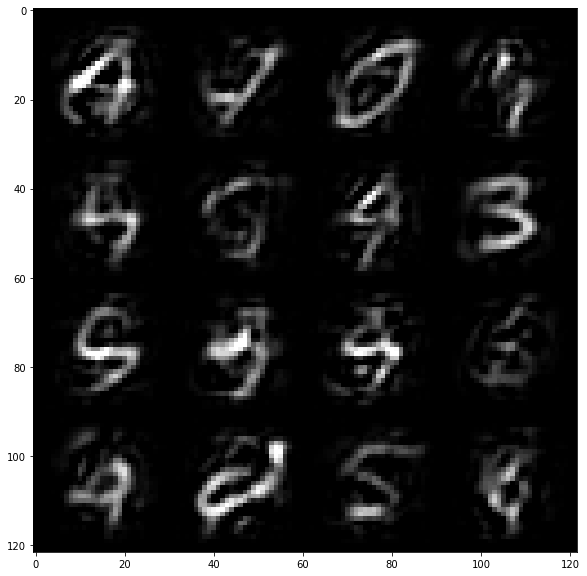

In [5]:
latent_sample = torch.randn(16, latent_size) # 16 instances of vectors of size latent_size drawn from a normal.

with torch.no_grad():
    decoded_digits = model.decode(latent_sample)
    decoded_digits = decoded_digits.detach().cpu().view(-1, 1, 28, 28) # Reshape into images.

ae_grid = vutils.make_grid(decoded_digits, nrow=4)
ae_grid = ae_grid.permute(1, 2, 0)
plt.figure(figsize=(13, 10))
plt.imshow(ae_grid)

What's going on here? The decoded digits look bad. We can't sample easily from the latent space of the regular autoencoder because we don't know where to look in this high-dimensional latent space. You can get lucky and actually produce real looking digits, but in a large-dimensional latent space this becomes pretty hard. The solution to this is to use a variational autoencoder.

## Variational Autoencoder

![On the left is the regular autoencoder and on the right the variational one.](vae.png)

The figure above shows a regular autoencoder on the left and a variational autoencoder on the right. The variational autoencoder learns the variance and the mean of a normal distribution that we sample from to generate images. The regular autoencoder just learns an arbitrary encoded representation. Something that I missed when reading the paper is that the layer that outputs the variance should actually be interpreted as generating the log(variance). Keep this in mind when implementing the class below.

In [6]:
class VAE(nn.Module):
    
    def __init__(self, latent_size):
        super(VAE, self).__init__()
        # Since you already coded the fully connected layers for the autoencoder, we won't
        # make you do it again.
        self.epsilon = Variable(torch.zeros(64,latent_size))
        
        self.latent_size = latent_size
        self.activation = F.relu
        self.efc1 = nn.Linear(784, 256)
        self.efc2 = nn.Linear(256, 128)
        self.efc3 = nn.Linear(128, 64)
        
        # TODO: what is the bottleneck layer in the variational autoencoder supposed
        # to output? Refer to the figure above. 
        self.mean = nn.Linear(64,self.latent_size)
        self.var =  nn.Linear(64,self.latent_size)

        # TODO: copy decoding code from your autoencoder class
        self.dfc1 = nn.Linear(latent_size, 256)
        self.dfc2 = nn.Linear(256, 512)
        self.dfc3 = nn.Linear(512, 784)
    
    def encode(self, x):
        x = self.efc1(x)
        x = self.activation(x)
        x = self.efc2(x)
        x = self.activation(x)
        x = self.efc3(x)
        x = self.activation(x)
        mu = self.mean(x)
        var = self.var(x)
        return mu,var
    
    
    def decode(self, z):
        x = self.dfc1(z)
        x = self.activation(x)
        x = self.dfc2(x)
        x = self.activation(x)
        x = self.dfc3(x)
        # The VAE seems to do a lot better on MNIST if we end the decoding 
        # step with a sigmoid and use binary cross entropy.
        return torch.sigmoid(x)
    
    def sample(self, logvariance, mu):
        sigma = torch.exp(0.5*logvariance)
        epsilon = torch.randn_like(sigma)
        z_sample = mu + sigma*epsilon
        return z_sample
        
    def forward(self, x):
        # TODO: create log(variance) and mean vectors with the encoder.
        mu, logvar = self.encode(x)
        # TODO: sample from the normal distribution described by the mean and variance vectors.
        # This is where the authors use the reparameterization trick.
        z = self.sample(logvar,mu)
        # TODO: Reconstruct the image from the sampled latent vector.
        img = self.decode(z)
        # Return the logvariance, mean, and reconstructed image for computing the loss.
        return logvar, mu, img


## The reparameterization trick 
![](reparam.png)

We want to sample from the normal distribution whose mean and variance we learn. 
$$z = \mu + \sigma*\epsilon,$$ where epsilon is drawn from $\mathcal{N}(0, I)$. In our case, we're sampling from a N-dimensional normal distribution, but the formula stays the same.


# KL Divergence
Now we have to implement the KL divergence part of the loss function. The authors of the original paper say that
$$D_{KL} = -\frac{1}{2}*\sum_j(1 + log(\sigma_j^2) - \mu_j^2 - \sigma_j^2).$$

The derivative will be taken care of by autodiff.

In [7]:
def closed_form_kl_div(mu, logvariance):
    dkl = (-0.5)*torch.sum(1 + logvariance - mu**2 - logvariance.exp())
    return dkl

In [ ]:
vae = VAE(latent_size).to(device)
opt_vae = torch.optim.Adam(vae.parameters(), lr=lr)
epochs = 5
for epoch in range(epochs):
    print('epoch', epoch+1)
    for i, (real_imgs, _) in enumerate(train_loader, 0):
        
        real_imgs = real_imgs.to(device)

        real_imgs = real_imgs.view(-1, 28*28)
        vae.zero_grad()
        
        
        logvar,mu,img = vae.forward(real_imgs)
        
        # TODO: calculate the KL divergence.
        kl_div = closed_form_kl_div(mu,logvar)
        
        # The VAE does a lot better if we use BCE
        BCE = F.binary_cross_entropy(img, real_imgs, reduction='sum')
        # TODO: What should the total loss funcion be?
        
        loss_vae = BCE + kl_div
        
        loss_vae.backward()
        opt_vae.step()
    print('Epoch: {}/{}.............{}'.format(epoch, epochs, loss_vae.item()), end='\n')
    

epoch 1
Epoch: 0/5.............8615.05078125
epoch 2


In [ ]:
normal_z = torch.randn(batch_size, latent_size).to(device)
with torch.no_grad():
    out_vae = vae.decode(normal_z).cpu().detach()
    out_vae = out_vae.view(-1, 1, 28, 28)
    out_ae = ae.decode(normal_z).cpu().detach()
    out_ae = out_ae.view(-1, 1, 28, 28)

vae_grid = vutils.make_grid(out_vae, nrow=8)
ae_grid = vutils.make_grid(out_ae, nrow=8)
vae_grid = vae_grid.permute(1, 2, 0)
ae_grid = ae_grid.permute(1, 2, 0)
fig, ax = plt.subplots(ncols=2, figsize=(13, 10))
ax[0].imshow(vae_grid)
ax[1].imshow(ae_grid)
ax[0].set_title("vae samples")
ax[1].set_title("ae samples")

The samples drawn from the VAE should look much better. Another way we can inspect the results is to visualize the latent space of both of the autoencoders. To do this, we'll use a dimensionality reduction technique called TSNE. We'll use the test set to do this.

In [ ]:

latent_reps_ae = np.zeros((batch_size*len(test_loader), latent_size)) 
# instances (batch_size * n_test) by latent_dim
latent_reps_vae = np.zeros((batch_size*len(test_loader), latent_size)) 
labels = np.zeros((batch_size*len(test_loader)))

for i, (real_img, label)  in enumerate(test_loader):
    with torch.no_grad():
        real_img = real_img.to(device)
        real_img = real_img.view(-1, 28*28)
        
        ae_encoded = ae.encode(real_img).detach().cpu()
        # TODO: How do you sample from the vae's latent space? First you need to generate
        # log(variance) and mu, then sample from the normal dist. 
        ???, ??? = vae.encode(real_img)
        vae_encoded = ???
        
        latent_reps_ae[i*batch_size:i*batch_size+batch_size, :] = ae_encoded
        latent_reps_vae[i*batch_size:i*batch_size+batch_size, :] = z_sample
        labels[i*batch_size:i*batch_size+batch_size] = label.cpu()

In [ ]:
from sklearn.manifold import TSNE
# Here is where we do the latent space dimensionality compression down to two dimensions
vae_embed = TSNE(n_components=2).fit_transform(latent_reps_vae)
ae_embed = TSNE(n_components=2).fit_transform(latent_reps_ae)

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(13, 11))
for i in range(10):
    ax[0].scatter(vae_embed[:, 0][labels==i], vae_embed[:, 1][labels==i], label=str(i))
    ax[1].scatter(ae_embed[:, 0][labels==i], ae_embed[:, 1][labels==i], label=str(i))

ax[0].legend()
ax[1].legend()

Further directions
1. What happens if you set the latent_size to 2? Can the regular autoencoder generate reasonable images? Why do you think this is? (Visualizing the latent space without a TNSE embedding gives some insight into this.)
